In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [41]:
class Pair_trading():
    def __init__(self, data_var,data_preco, par, valor_inicial):
        self.financeiro = valor_inicial
        self.posicionado = 0 #comeca sem nenhuma operação aberta
        self.lista_resultado_operacoes = []
        self.lista_evolucao_carteira = []
        self.lista_dias_carregando = []
        self.lista_rentabilidade_operacao = []
        self.contador_dias = 0 
        self.perm_pct_acumulado = 1
        #guarda tickers das acoes
        self.t1 = par[0] 
        self.t2 = par[1]
        self.volume_operacao = 0

        self.dados_var = data_var
        self.dados_preco = data_preco

    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs
        
    def condicoes_operar(self,zs, gatilho_high, preco_s1, preco_s2, index):
        if zs >= gatilho_high and self.posicionado == 0:
            #parametros para iniciar operacao
            self.posicionado = 1 #entrou em uma operacao            
            self.volume = (self.financeiro/2)//preco_s1
            self.razao = preco_s1/preco_s2
            self.contador_dias = index
            #guarda dados de quantas ações está comprado/vendido
            self.qtd_s1 =  self.volume
            self.qtd_s2 =  self.volume*self.razao
            #calcula valor total da compra e venda (idealmente devem ser iguais)
            valor_operado_s1 =  preco_s1*self.qtd_s1 #vende  s1 (credita caixa)
            valor_operado_s2 = -preco_s2*self.qtd_s2 #compra s2 (debita caixa) 
#             print(f'v1  R${valor_operado_s1:.2f} | v2 R${valor_operado_s2:.2f}')
#             print(f'C1  R${preco_s1:.2f} | D2 R${(preco_s2*self.razao):.2f}')
            self.financeiro += valor_operado_s1 + valor_operado_s2

        elif zs <= 0.08 and self.posicionado == 1:
            #calcula preço das açoes que estão em carteira
            valor_operado_s1 = -self.qtd_s1*preco_s1 #compra s1 (debita  caixa) 
            valor_operado_s2 =  self.qtd_s2*preco_s2 #vende  s2 (credita caixa)
#             print(f'v1 R${valor_operado_s1:.2f} | v2  R${valor_operado_s2:.2f}')
#             print(f'D1  R${preco_s1:.2f} | C2 R${(preco_s2*self.razao):.2f}')
            resultado_trade = valor_operado_s1 + valor_operado_s2 
#             print(f'resu: R${resultado_trade:.2f}\n')
            self.financeiro += resultado_trade 
            #zera quantidades de ações sendo operadas
            self.qtd_s1 -= self.qtd_s1
            self.qtd_s2 -= self.qtd_s2
            #guarda dados para acompanhamento ao longo do tempo
            pct_change_trade = resultado_trade/(self.financeiro-resultado_trade)
            self.perm_pct_acumulado = self.perm_pct_acumulado*(1+pct_change_trade)
            self.lista_rentabilidade_operacao.append(pct_change_trade*100)
            self.lista_evolucao_carteira.append(self.financeiro)
            self.lista_dias_carregando.append(index-self.contador_dias)
            self.lista_resultado_operacoes.append(resultado_trade)
            #zera parametros para próximas operações 
            self.posicionado = 0
            self.razao = 0
            self.volume = 0
            self.contador_dias = 0
        
    def opera(self):
        period = 45
        c = 0
        s1 = self.dados_var[self.t1]
        s2 = self.dados_var[self.t2]
        for index in range(period, len(self.dados_var)):
            j1 = (s1[c:index]) #seleciona a acao 1 com uma janela com *period* dias 
            j2 = (s2[c:index])

            preco_s1 = self.dados_preco[self.t1][self.dados_var.index == index].values[0]
            preco_s2 = self.dados_preco[self.t2][self.dados_var.index == index].values[0]
            
            zs = self.calcula_zscore_spread(stock1=j1,stock2=j2)
            self.condicoes_operar(zs=zs, gatilho_high = 1.1, preco_s1=preco_s1, preco_s2=preco_s2, index=index)
            c += 1

        

In [42]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')[1:]
data_var = data.drop('time',axis=1).pct_change()[1:1481]
data_preco = data[1:1481]

In [43]:
print(data.columns.tolist())

['time', 'close IBOV', 'close ABEV3', 'close AZUL4', 'close B3SA3', 'close BBAS3', 'close BBDC3', 'close BBDC4', 'close BBSE3', 'close BEEF3', 'close BPAC11', 'close BRAP4', 'close BRDT3', 'close BRFS3', 'close BRKM5', 'close BRML3', 'close BTOW3', 'close CCRO3', 'close CIEL3', 'close CMIG4', 'close COGN3', 'close CPFE3', 'close CRFB3', 'close CSAN3', 'close CSNA3', 'close CVCB3', 'close CYRE3', 'close ECOR3', 'close EGIE3', 'close ELET3', 'close ELET6', 'close EMBR3', 'close ENBR3', 'close ENGI11', 'close EQTL3', 'close FLRY3', 'close GGBR4', 'close GNDI3', 'close GOAU4', 'close GOLL4', 'close HAPV3', 'close HGTX3', 'close HYPE3', 'close IGTA3', 'close IRBR3', 'close ITSA4', 'close ITUB4', 'close JBSS3', 'close KLBN11', 'close LAME4', 'close LREN3', 'close MGLU3', 'close MRFG3', 'close MRVE3', 'close MULT3', 'close NTCO3', 'close PETR3', 'close PETR4', 'close QUAL3', 'close RADL3', 'close RAIL3', 'close RENT3', 'close SANB11', 'close SBSP3', 'close SULA11', 'close SUZB3', 'close TAEE1

In [44]:
tickers = [['close BBDC3','close BTOW3'],['close ECOR3','close GOLL4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']

In [45]:
lista_pares_usados = []
dic = {}
for i in tickers:
    a = (i[0]+' x '+i[1])
    lista_pares_usados.append(a)
    dic[a] = Pair_trading(data_var=data_var, data_preco=data_preco, par=i, valor_inicial=1000)
    dic[a].opera()


<ipython-input-41-bacfedbbc313>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.volume = (self.financeiro/2)//preco_s1


In [46]:
for k,v in dic.items():
    print(k)

close BBDC3 x close BTOW3
close ECOR3 x close GOLL4
close CSNA3 x close MRFG3
close QUAL3 x close USIM5


Valor final em carteira: R$640406.46
peformance acumulado 64040.65% em 130 operações


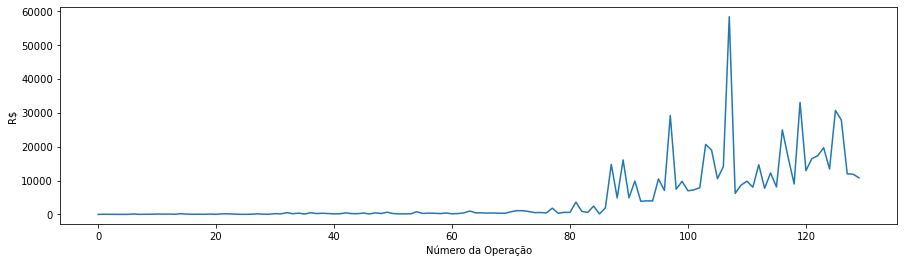

In [47]:
plt.figure(figsize=[15,4])
l1 = dic[lista_pares_usados[1]].lista_resultado_operacoes
l2 = dic[lista_pares_usados[1]].financeiro
l3 = dic[lista_pares_usados[1]].perm_pct_acumulado
print(f'Valor final em carteira: R${l2:.2f}')
print(f'peformance acumulado {l3*100:.2f}% em {len(l1)} operações')
plt.plot(l1)
plt.ylabel('R$')
plt.xlabel('Número da Operação')
plt.show()

In [48]:
print('Informações sobre o ganho em R$ das operações')
l1_series = pd.DataFrame(l1)
print(l1_series.describe())

Informações sobre o ganho em R$ das operações
                  0
count    130.000000
mean    4918.511223
std     8673.632370
min        8.649972
25%      174.422637
50%      466.779527
75%     7668.330306
max    58444.960190


In [49]:
for k,v in dic.items():
    lista_dias_series = pd.Series(v.lista_rentabilidade_operacao)
    print(k,lista_dias_series.describe(),'\n |||||||||||||||||||||||||||||||||||||||||||')  

close BBDC3 x close BTOW3 count    129.000000
mean       5.096692
std        4.330391
min       -0.011851
25%        2.411288
50%        3.856066
75%        6.356625
max       28.799864
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close ECOR3 x close GOLL4 count    130.000000
mean       5.217040
std        5.352206
min        0.451747
25%        2.360593
50%        3.485951
75%        6.037664
max       41.213055
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close CSNA3 x close MRFG3 count    138.000000
mean       3.685976
std        3.737130
min       -1.649171
25%        1.541851
50%        3.006675
75%        4.650768
max       26.094207
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close QUAL3 x close USIM5 count    80.000000
mean      3.830554
std       3.252324
min      -0.232741
25%       1.990371
50%       2.918816
75%       4.415021
max      21.794291
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||


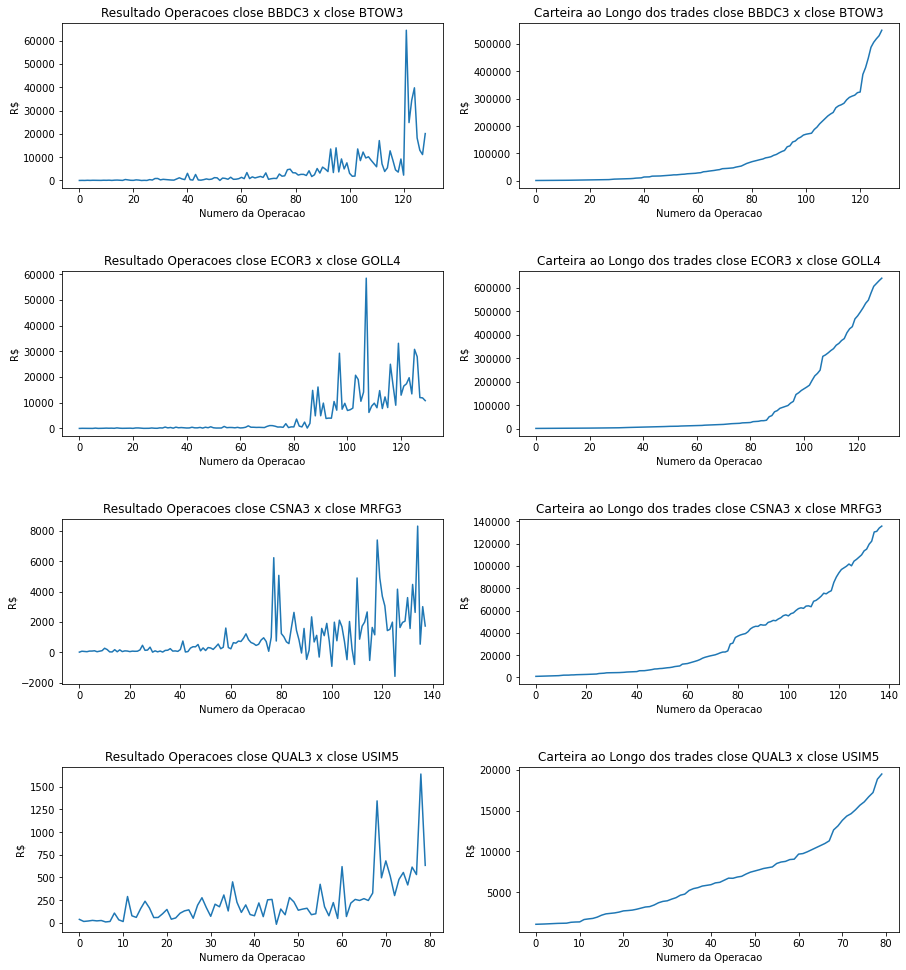

In [50]:
fig = plt.figure(figsize=(15, 30))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_resultado_operacoes)
    plt.title('Resultado Operacoes '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    
    contador1 += 1
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_evolucao_carteira)
    plt.title('Carteira ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')

    contador1 += 1
    
plt.show()

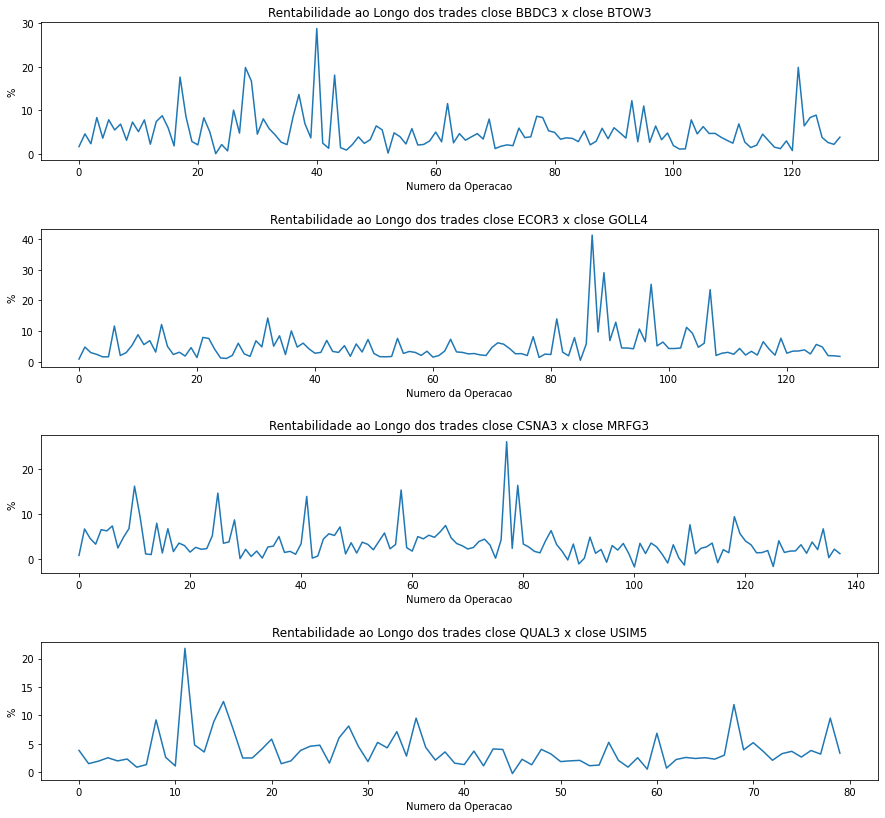

In [51]:
fig = plt.figure(figsize=(15, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    
#     plt.subplot(8, 2, contador1)
#     plt.hist(dic[i].lista_dias_carregando, bins=8)
#     plt.title('Dias Posicionado '+ i)
#     plt.xlabel('Numero da Operacao')
#     plt.ylabel('R$')
#     contador1+=1

    plt.subplot(8, 1, contador1)
    plt.plot(dic[i].lista_rentabilidade_operacao)
    plt.title('Rentabilidade ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('%')

    contador1 += 1

plt.show()